# Generate AGU 2018 poster figs: BD + NH3

4 Dec 2018

Try to reduce complexity of figures. Also now have processed low-NH3 concentration vial experiments.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyccutof as pt
import pyvap as pv
import seaborn as sns
import sys

sns.set_context(context="poster", font_scale=1, rc=None)
sns.set_style("white")

In [2]:
# import makefigs functions
sys.path.append(os.path.join(os.path.curdir, '..', '..', 'writing', 'pegpaper'))
import makefigs
# tell makefigs where to load the params from
makefigs.init_pars(os.path.join("..","..","writing","pegpaper","params.yaml"))

In [3]:
data_path = '/n/keutsch_lab/DATA/droplet/data/drop-out/bd-as-all/bd-as-all.csv'
expts = pd.read_csv(data_path)
expts['d'] = makefigs.calcdiam(expts)

Need to add other data that is (temporarily ?) elsewhere.

In [4]:
eic_heights_path = '/n/keutsch_lab/DATA/droplet/calc/ipynb/181026-df-eic-heights.csv'
col_rename = {"Unnamed: 0": "path",
              "solution": "comp",
              "nominal_nh3_molarity": "nh3_bubbler",
              "np84": "n84",
              "np85": "n85",
              "np149": "n149"}
expts_aux = pd.read_csv(eic_heights_path).rename(columns=col_rename)

Manipulate `expts_aux` so it can be appended to `expts`. Want to include:

- date
- file
- p### for p### when signal_### is True
- n### (already has 0 when signal_### is False)
- comp
- signal (all True)
- trapped
- nh3_bubbler
- comptype
- compnum

In [5]:
def extract_file(path):
    # assume path is series of strings divided by "/"
    parts = path.split("/")
    # assume datastr is in format Data###.7rw
    # extract ### and convert to float
    datastr = parts[-1]
    file = float(datastr.split(".")[0][4:])
    return file

def extract_date(path):
    # assume path is series of strings divided by "/"
    parts = path.split("/")
    # assume datestr is in format YYMMDD.7fl
    # extract YYMMDD and convert to int
    datestr = parts[-2]
    date = int(datestr.split(".")[0])
    return date

def extract_comptype(comp):
    return comp.split("_")[0]

def extract_compnum(comp):
    parts = comp.split("_")
    if len(parts)<=1:
        return np.nan
    else:
        return int(parts[1])

expts_aux['date'] = expts_aux.path.apply(extract_date)
expts_aux['file'] = expts_aux.path.apply(extract_file)
expts_aux['comptype'] = expts_aux.comp.apply(extract_comptype)
expts_aux['compnum'] = expts_aux.comp.apply(extract_compnum)
expts_aux['signal'] = True

# put nan where signal for peak not present
expts_aux['p84'] = expts_aux.where(expts_aux.signal_84).p84
expts_aux['p85'] = expts_aux.where(expts_aux.signal_85).p85
expts_aux['p149'] = expts_aux.where(expts_aux.signal_149).p149

# to make clear source
expts_aux['from_aux'] = True
expts['from_aux'] = False

4 csv files contain vial aqueous ammonia experiments. Don't include one with added sodium hydroxide.

In [6]:
df1 = pd.read_csv("181113-df-nh160mM.csv")
df1["nh3_vial"] = 0.160
df2 = pd.read_csv("181113-df-nh320mM.csv")
df2["nh3_vial"] = 0.320
df3 = pd.read_csv("181113-df-nh650mM.csv")
df3["nh3_vial"] = 0.650
# don't include added sodium hydroxide data
# df4 = pd.read_csv("181113-df-nh160mM-sh010mM.csv")
# df4["nh3_vial"] = 0.160

expts_aqnh3 = df1.append(df2).append(df3)

Combine all expts

In [7]:
to_drop = ['ln_np84','ln_np149']
expts_full = (expts.append([expts_aux.drop(columns=to_drop), expts_aqnh3], sort=False)
                   .reset_index()
                   .drop(columns='index'))
expts_full.nh3_bubbler.fillna(0, inplace=True)
expts_full.head()

,date,file,chrom,dc_trap,mfc,src1,src2,signal,vialstart,trapstart,...,naoh_vial,d,from_aux,path,p149,nh3,signal_84,signal_85,signal_149,n149
0,180808,5.0,0.98,630.0,235.0,NaN,NaN,1,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,180808,5.0,22.45,420.0,218.0,NaN,NaN,1,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,180808,5.0,41.03,390.0,230.0,NaN,NaN,1,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,180809,1.0,1.84,300.0,205.0,NaN,NaN,1,NaN,NaN,...,NaN,inf,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,180809,1.0,21.07,470.0,250.0,NaN,NaN,1,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check for duplicates (WIP)

In [8]:
expts_full['datefile'] = expts_full.apply(lambda x: "{}_{}".format(str(int(x.date)),str(int(x.file))), axis=1)
dups = expts_full.datefile.duplicated(keep=False)

# unique chrom times in dups
dup_chroms = (expts_full[dups].groupby("datefile").apply(lambda x: x.chrom.isna().any()))
dup_chroms.head()
#     .loc[:,['datefile','date','file','chrom','comp','nh3_bubbler','from_aux']]
#     .sort_values(["date","file"],ascending=True))

datefile
180808_5    False
180809_1    False
180810_2    False
180814_1    False
180814_3    False
dtype: bool

## Plots

### NH3 flowing around droplet and in vial

In [9]:
drop_nh3 = expts_full.query("nh3_bubbler>0 and from_aux")
vial_nh3 = expts_full.query("nh3_vial>0 and vial<500")
print("drop NH3 concs: {}".format(drop_nh3.nh3_bubbler.unique()))
print("vial NH3 concs: {}".format(vial_nh3.nh3_vial.unique()))

drop NH3 concs: [1.45e+00 1.45e-01 1.45e-02 2.90e-03 5.80e-04]
vial NH3 concs: [0.0029 0.029  0.29   0.16   0.32   0.65  ]


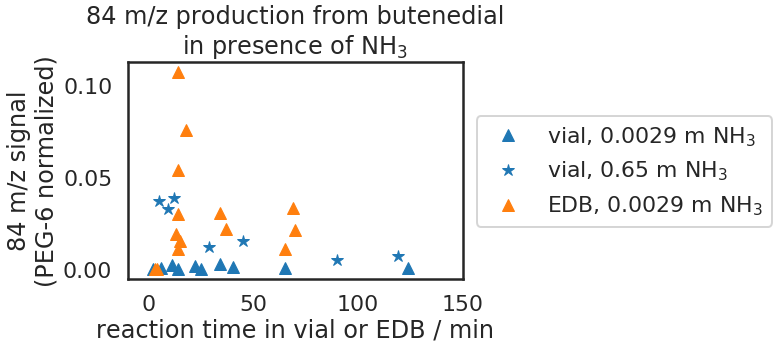

In [10]:
drop_nh3_plot = drop_nh3.query("nh3_bubbler==0.0029")
vial_nh3_plot_0029 = vial_nh3.query("nh3_vial==0.0029")
vial_nh3_plot_65 = vial_nh3.query("nh3_vial==0.65")

plt.plot("vial","n84",data=vial_nh3_plot_0029,label=r"vial, 0.0029 m NH$_3$",
         linestyle='None', marker='^', color="C0")

plt.plot("vial","n84",data=vial_nh3_plot_65,label=r"vial, 0.65 m NH$_3$",
         linestyle='None', marker='*', color="C0")

plt.plot("trapped","n84",data=drop_nh3_plot,label=r"EDB, 0.0029 m NH$_3$",
        linestyle='None', marker='^', color="C1")

plt.title("84 m/z production from butenedial\n"
             r"in presence of NH$_3$")
plt.xlabel("reaction time in vial or EDB / min")
plt.ylabel("84 m/z signal\n"
           "(PEG-6 normalized)")
plt.xlim(-10,150)
plt.legend(loc='upper left',bbox_to_anchor=(1.01,.8))
plt.savefig("out_png/181204-agu18-figs-bd-nh3-edb-vial.png",bbox_inches='tight')

### AS in vial and droplet

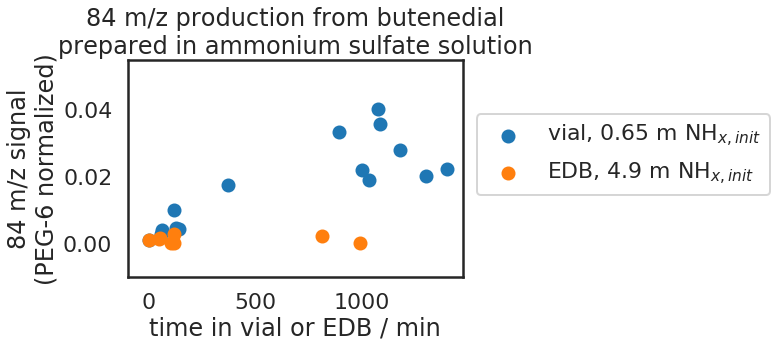

In [58]:
bad_pt_idx = 230 # known contamination

# vial
as_vial_query = "from_aux==False and comptype=='bd07hg20as03' and trapped<10 and p283>30000"
as_vial = expts_full.query(as_vial_query).drop(bad_pt_idx)
plt.scatter("vial","n84",data=as_vial, label='vial, 0.65 m NH$_{x,init}$')

# droplet in edb
as_drop_query = "from_aux==False and comptype=='bd07hg20as03' and vial<10"
as_drop = expts_full.query(as_drop_query).drop(bad_pt_idx)
plt.scatter("trapped","n84",data=as_drop,label='EDB, 4.9 m NH$_{x,init}$')

plt.xlabel("time in vial or EDB / min")
plt.ylabel("84 m/z signal\n"
           "(PEG-6 normalized)")
plt.ylim(-0.01, 0.055)
plt.legend(loc='upper left',bbox_to_anchor=(1.01,.8))
plt.title("84 m/z production from butenedial\n"
          "prepared in ammonium sulfate solution")
plt.savefig("out_png/181204-agu18-figs-bd-as-edb-vial.png", bbox_inches='tight')

### AS v. NH3 effect in vial (pH proxy?)

Set up break in x axis to show different time scales

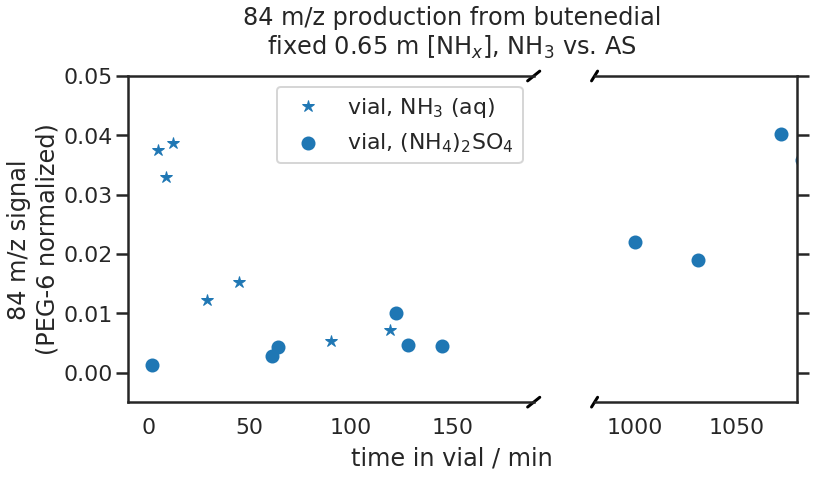

In [55]:
f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w', gridspec_kw = {'width_ratios':[2, 1]}, figsize=(12,6))

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright=False)
ax2.yaxis.tick_right()

# diagonal lines to show interruption
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)


as_vial_query = "from_aux==False and comptype=='bd07hg20as03' and trapped<10 and p283>30000"
as_vial = expts_full.query(as_vial_query).drop(bad_pt_idx)
ax.scatter("vial","n84",data=as_vial, label=r'vial, (NH$_4$)$_2$SO$_4$')
ax2.scatter("vial","n84",data=as_vial, label=r'vial, (NH$_4$)$_2$SO$_4$')


vial_nh3_plot_65 = vial_nh3.query("nh3_vial==0.65")
ax.plot("vial","n84",data=vial_nh3_plot_65,label=r"vial, NH$_3$ (aq)",
         linestyle='None', marker='*', color="C0")
ax2.plot("vial","n84",data=vial_nh3_plot_65,label=r"vial, NH$_3$ (aq)",
         linestyle='None', marker='*', color="C0")

# shared xlabel
f.text(0.5, -0.02, "time in vial / min", ha='center', size=24)
ax.set_ylabel("84 m/z signal\n"
           "(PEG-6 normalized)")
ax.set_xlim(-10,190)
ax2.set_xlim(980,1080)
ax.set_ylim(-0.005, 0.05)
ax.legend(loc='best')#,bbox_to_anchor=(1.01,.8))
f.suptitle("84 m/z production from butenedial\n"
           "fixed 0.65 m [NH$_x$], NH$_3$ vs. AS", size=24, y=1.04)
plt.savefig("out_png/181205-agu18-figs-as-nh3-vial.png", bbox_inches='tight')